# Exploratory Data Analysis: Greenhouse Gases  
**Data Source**: Processed NOAA data (cleaned in `1_data_loading.ipynb`)  

## Key Notes  
- **Focus Gas**: CH₄ (Methane) - primary analysis target  
- **Data Quality**:  
  - Missing values: All rows kept (missing values → `NaN`)  
  - Negative values: Converted to `NaN` (non-physical concentrations)  
  - Data start dates: Gases have distinct collection start dates  
- Raw data pipeline documented in [`1_data_loading.ipynb`](../notebooks/1_data_loading.ipynb)  

## Data Files  
- **Input**: `../data/processed/all_ghg_aligned.csv`  
- **Output**: `../data/processed/all_ghg_aligned_nan.csv`  

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import os
from statsmodels.tsa.stattools import adfuller, kpss

# Make Directory

In [2]:
# automatic path handling
NOTEBOOK_PATH = Path.cwd() # gets current working directory
if 'notebooks' in str(NOTEBOOK_PATH): # if running from /notebooks/
    PROCESSED_DATA = NOTEBOOK_PATH.parent / 'data' / 'processed'
else: # if running from the repo root
    PROCESSED_DATA = NOTEBOOK_PATH / 'data' / 'processed'

# create folder (if necessary)
PROCESSED_DATA.mkdir(parents=True, exist_ok=True)

# Load Data

In [3]:
df_combined = pd.read_csv("../data/processed/all_ghg_aligned.csv", parse_dates=['date'])

In [4]:
df_combined.head()

,date,CH4,CO,CO2,H2,N2O,SF6
0,1969-08-20,NaN,NaN,-5.2700,NaN,NaN,NaN
1,1969-08-27,NaN,NaN,-2.1625,NaN,NaN,NaN
2,1969-09-02,NaN,NaN,-9.1150,NaN,NaN,NaN
3,1969-09-12,NaN,NaN,320.9450,NaN,NaN,NaN
4,1969-09-24,NaN,NaN,320.8900,NaN,NaN,NaN


# EDA 

## Overview

In [5]:
df_combined.describe()

,date,CH4,CO,CO2,H2,N2O,SF6
count,2562,2131.000000,1825.000000,2561.000000,790.000000,1498.000000,1496.000000
mean,2000-04-04 02:32:19.110070400,1786.120962,91.608401,366.723396,543.061065,323.711850,6.416216
min,1969-08-20 00:00:00,-99.433333,-999.990000,-551.175667,226.026000,58.226000,-246.425000
25%,1987-10-24 18:00:00,1753.305000,77.117500,349.615000,535.398750,318.040625,5.290000
50%,2000-05-01 12:00:00,1791.180000,89.965000,370.000000,544.222500,323.672500,7.176250
75%,2012-08-27 18:00:00,1842.661250,105.540000,394.692500,553.233125,330.458125,9.492500
max,2025-04-03 00:00:00,1989.377500,248.642500,508.151750,596.360000,339.212500,12.345000
std,NaN,133.264558,46.026747,62.016673,23.384055,15.493204,14.933516


## Datatypes

In [6]:
df_combined.dtypes

date    datetime64[ns]
CH4            float64
CO             float64
CO2            float64
H2             float64
N2O            float64
SF6            float64
dtype: object

## Null Values

In [7]:
df_combined.isnull().sum()

date       0
CH4      431
CO       737
CO2        1
H2      1772
N2O     1064
SF6     1066
dtype: int64

In [8]:
# the fill values for 'values' is -999.999.  This is essentially the same as a null value.  
# So, I will check on the number of fill values.  

fillvalue_counts = (df_combined == -999.999).sum()
fillvalue_counts

date    0
CH4     0
CO      0
CO2     0
H2      0
N2O     0
SF6     0
dtype: int64

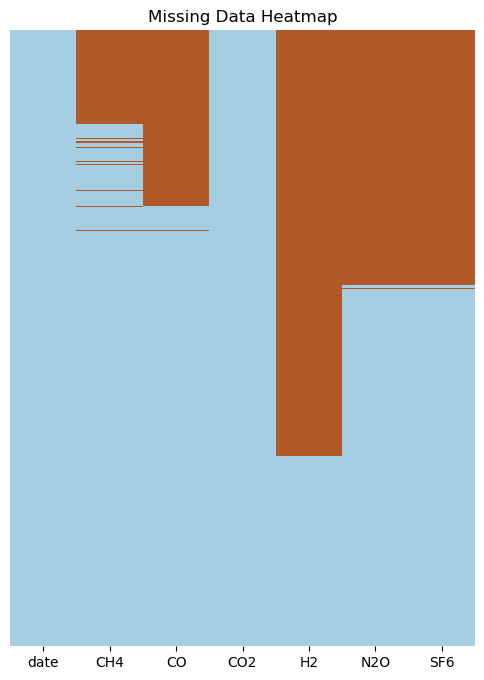

In [9]:
# visualize location of null values for each feature

plt.figure(figsize=(6,8))
sns.heatmap(df_combined.isnull(), cmap='Paired', cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

Null (NaN) values are data points that were not collected or recorded. Many null values occur at the beginning of the timeseries for each gas, except CO2, since measurement of the other gases began after the first CO2 measurement. 

## measurement start dates:
- CO2: 1969-8-20
- CH4: 1983-5-6
- CO: 1989-7-7
- N2O: 1995-12-15
- SF6: 1995-12-15

I will not impute any null value that exist at dates earlier than the first measurement date for each gas.

## Negative Values

In [10]:
# There are some negative values for gas concentration.  This doesn't make physical sense. 
# One possible explanation is that the GC sensor was zeroed incorrectly. Either way, I will 
# likely set them to NaN.  First, inspect:

neg_value_count = (df_combined.iloc[:,1:] < 0).sum()
print('----- Negative Value Count per Gas Type -----')
print(neg_value_count)

----- Negative Value Count per Gas Type -----
CH4     1
CO     10
CO2    16
H2      0
N2O     0
SF6     7
dtype: int64


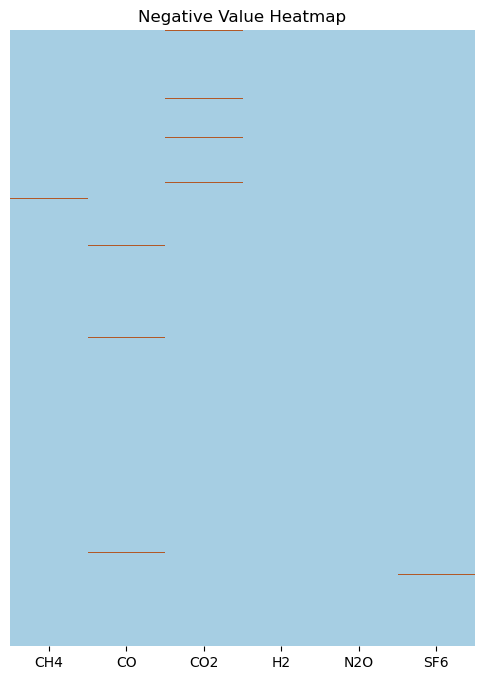

In [11]:
# visualize the location of the negative values

plt.figure(figsize=(6,8))
sns.heatmap(df_combined.iloc[:,1:] < 0, cmap='Paired', cbar=False, yticklabels=False)
plt.title('Negative Value Heatmap')
plt.show()

In [12]:
# replace negative values with NaN

df_combined.iloc[:,1:] = df_combined.iloc[:,1:].mask(df_combined.iloc[:,1:] < 0, np.nan)
                          
new_neg_count = (df_combined.iloc[:,1:] < 0).sum()
print('----- Remaininig Negative Values per Gas Type -----')
print(new_neg_count)

----- Remaininig Negative Values per Gas Type -----
CH4    0
CO     0
CO2    0
H2     0
N2O    0
SF6    0
dtype: int64


All NaN values that originate after the data collection start date will be imputed during preprocessing.  

## Store New Dateframe as CSV

In [13]:
print(f'Processed data will save to: {PROCESSED_DATA}')
df_combined.to_csv(PROCESSED_DATA / 'all_ghg_aligned_nan.csv', index=False)

Processed data will save to: C:\Users\aplor\Documents\GitHub\greenhouse-gas-forecasting\data\processed


## Visualize Data and Run Stationarity Tests

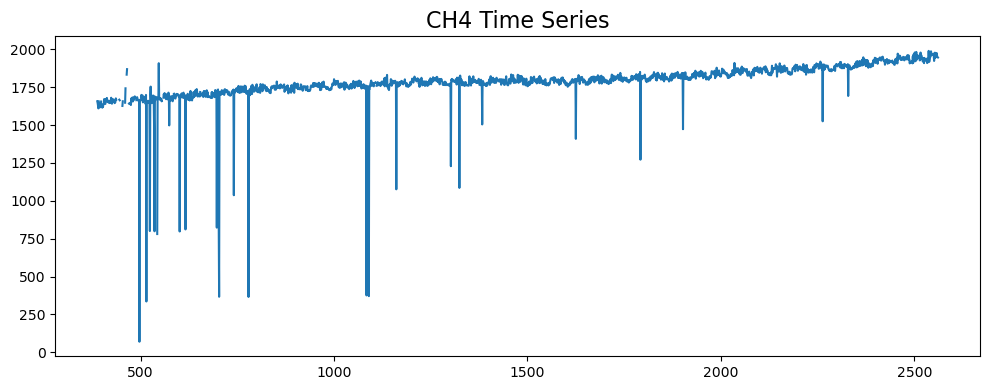

ADF and KPSS tests for CH4:
ADF statistic -2.0896
ADF p-value 0.2487
ADF critical values: {'1%': -3.4334618327378696, '5%': -2.8629146774725713, '10%': -2.5675018132490712}

KPSS statistic 6.7865
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the CH4 time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_8432\3927959642.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


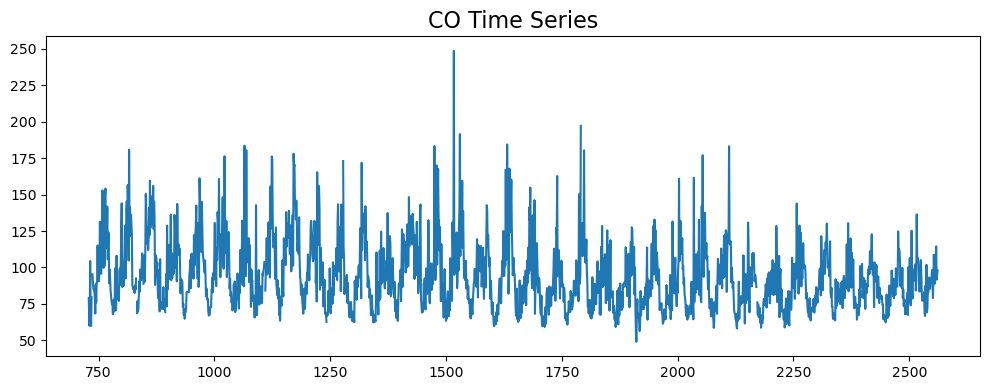

C:\Users\aplor\AppData\Local\Temp\ipykernel_8432\3927959642.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF and KPSS tests for CO:
ADF statistic -10.6642
ADF p-value 0.0000
ADF critical values: {'1%': -3.4340044039750235, '5%': -2.863154216066867, '10%': -2.5676293568762953}

KPSS statistic 1.5200
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the CO time series may be difference-stationary according to ADF and KPSS tests.



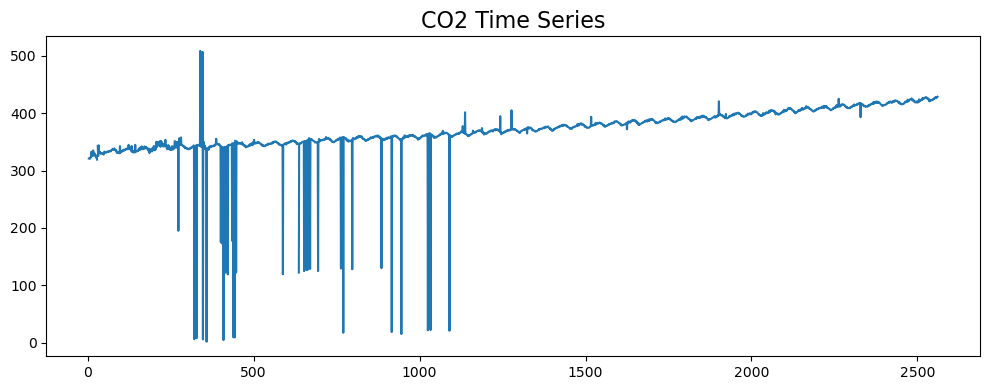

ADF and KPSS tests for CO2:
ADF statistic -1.7131
ADF p-value 0.4244
ADF critical values: {'1%': -3.4329507078222634, '5%': -2.8626889823128554, '10%': -2.567381647203466}

KPSS statistic 8.4353
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the CO2 time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_8432\3927959642.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


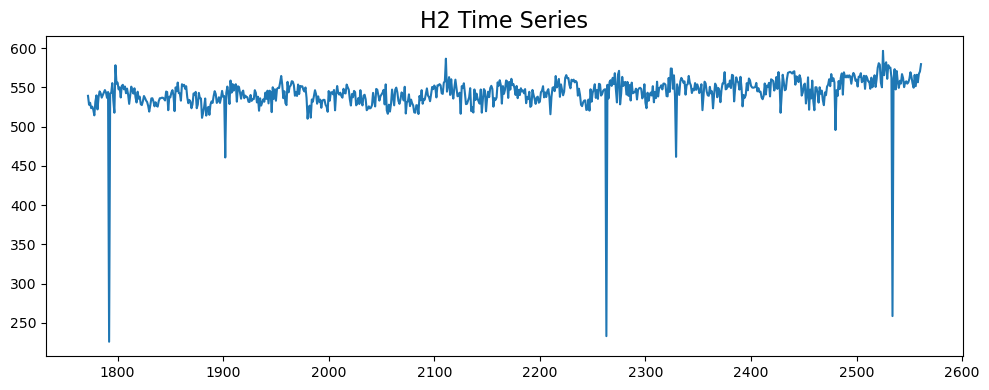

ADF and KPSS tests for H2:
ADF statistic -9.2911
ADF p-value 0.0000
ADF critical values: {'1%': -3.438707722728768, '5%': -2.8652288644673125, '10%': -2.568734303622865}

KPSS statistic 2.8829
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the H2 time series may be difference-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_8432\3927959642.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


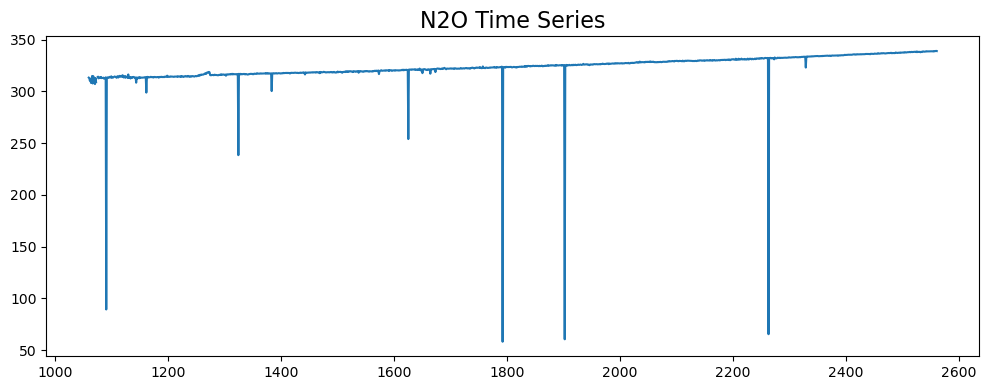

C:\Users\aplor\AppData\Local\Temp\ipykernel_8432\3927959642.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


ADF and KPSS tests for N2O:
ADF statistic -2.6079
ADF p-value 0.0914
ADF critical values: {'1%': -3.434791163965702, '5%': -2.8635014840083945, '10%': -2.5678142741740877}

KPSS statistic 5.9603
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the N2O time series is non-stationary according to ADF and KPSS tests.



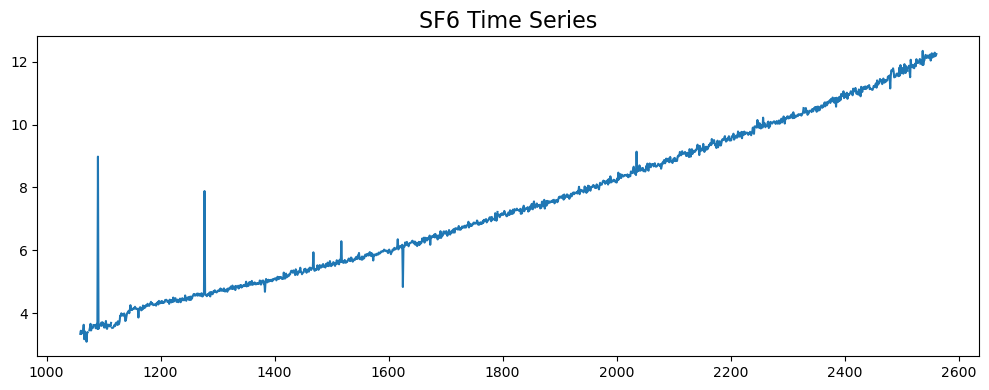

ADF and KPSS tests for SF6:
ADF statistic 1.7606
ADF p-value 0.9983
ADF critical values: {'1%': -3.434815425568625, '5%': -2.8635121913888306, '10%': -2.567819976000063}

KPSS statistic 5.7877
KPSS p-value 0.0100
KPSS critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

the SF6 time series is non-stationary according to ADF and KPSS tests.



C:\Users\aplor\AppData\Local\Temp\ipykernel_8432\3927959642.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


In [14]:
gas_columns = ['CH4','CO','CO2','H2','N2O','SF6']

# function to check stationarity
def check_stationarity(series, gas):
    adf_result = adfuller(series.dropna())
    kpss_result = kpss(series.dropna(), regression='c')

    print(f'ADF and KPSS tests for {gas}:')
    print(f'ADF statistic {adf_result[0]:.4f}')
    print(f'ADF p-value {adf_result[1]:.4f}')
    print(f'ADF critical values: {adf_result[4]}\n')
    
    print(f'KPSS statistic {kpss_result[0]:.4f}')
    print(f'KPSS p-value {kpss_result[1]:.4f}')
    print(f'KPSS critical values: {kpss_result[3]}\n')

    if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
        print(f'the {gas} time series is likely stationary according to ADF and KPSS tests.\n')
    elif adf_result[1] > 0.05 and kpss_result[1] < 0.05:
        print(f'the {gas} time series is non-stationary according to ADF and KPSS tests.\n')
    elif adf_result[1] > 0.05 and kpss_result[1] > 0.05:
        print(f'the {gas} time series may be trend-stationary according to ADF and KPSS tests.\n')
    else: 
        print(f'the {gas} time series may be difference-stationary according to ADF and KPSS tests.\n')

# plot raw data and perform the ADF test
for gas in gas_columns:
    plt.figure(figsize=(10,4))
    plt.plot(df_combined[gas], label=gas)
    plt.title(f'{gas} Time Series', fontsize=16)
    plt.tight_layout()
    plt.show()

    check_stationarity(df_combined[gas], gas)

## Data Distribution

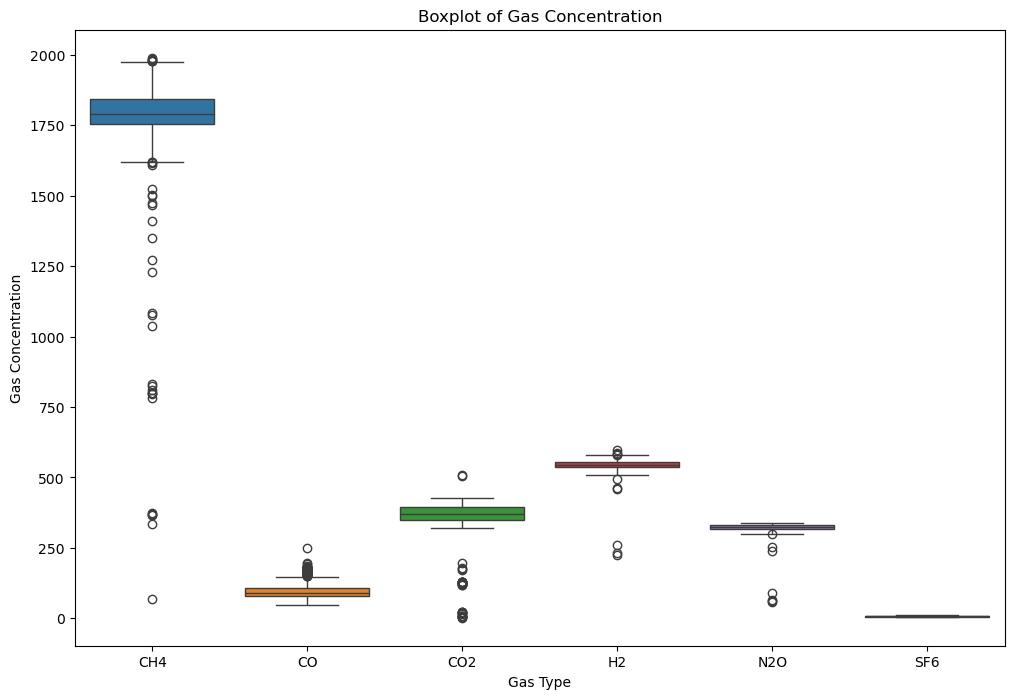

In [15]:
# inspect the distribution and outliers of each dataset

plt.figure(figsize=(12,8))
sns.boxplot(data=df_combined.iloc[:,1:])
plt.title('Boxplot of Gas Concentration')
plt.ylabel('Gas Concentration')
plt.xlabel('Gas Type')
plt.show()

All data series have significant outliers, with the possible exception of SF6, according to the box plot.  According to the ADF and KPSS tests, all series are nonstationary, which is to be expected if the concentration of each gas is increasing over time.  Additionally, there appears to be seasonality in all gases, though it's more difficult to see it in the plots above due to the maginitude of outliers.  Seasonality, etc will be better assessed when exploring each gas more thoroughly and each has been preprocessed for outliers.  

## Data Frequency (per year)

In [16]:
# The seasonality appears as a single cycle per year for each gas. 
# Confirm the number of datapoints per year for each gas.

df_counts = df_combined.copy()

df_counts['year'] = df_counts['date'].dt.year # extract the year
yearly_counts = df_counts.groupby('year').count()
yearly_counts

,date,CH4,CO,CO2,H2,N2O,SF6
year,,,,,,,
1969,10,0,0,7,0,0,0
1970,21,0,0,19,0,0,0
1971,2,0,0,2,0,0,0
1974,1,0,0,1,0,0,0
1976,25,0,0,25,0,0,0
1977,47,0,0,47,0,0,0
1978,48,0,0,47,0,0,0
1979,52,0,0,52,0,0,0
1980,58,0,0,56,0,0,0


In [17]:
# As expected, there is variation in the number of data points per year.  
# I will determine and use the mode of each gas for signal decomposition, preprocessing, and modeling.

seasonal_mode = yearly_counts.replace(0, np.nan).mode().iloc[0] 
seasonal_mode

date    52.0
CH4     52.0
CO      52.0
CO2     52.0
H2      52.0
N2O     52.0
SF6     52.0
Name: 0, dtype: float64

The yearly mode for each data series is 52, which means that the data is generally collected weekly.  